In [1]:
import io
import boto3
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected" # Set to "svg" or "png" for static plots or "notebook_connected" for interactive plots

In [2]:
formatter = ('cpg0016-jump/{Metadata_Source}/workspace/profiles/'
             '{Metadata_Batch}/{Metadata_Plate}/{Metadata_Plate}.parquet')

def get_s3_path(row):
    return formatter.format(**row.to_dict())

def read_parquet(s3_client, bucket, path):
    response = s3_client.get_object(Bucket=bucket, Key=path)
    status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")
    if status != 200:
        raise ValueError('Unable to read file')

    data = io.BytesIO(response['Body'].read())
    return pd.read_parquet(data)

def read_csv(s3_client, bucket, path, nrows):
    response = s3_client.get_object(Bucket=bucket, Key=path)
    status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")
    if status != 200:
        raise ValueError('Unable to read file')

    data = response['Body']
    if path.endswith('gz'):
        gzipped = GzipFile(None, 'rb', fileobj=data)
        data = TextIOWrapper(gzipped)

    return pd.read_csv(data, nrows=nrows)

In [3]:
aws_profile = 'jump-cp-role'
bucket = 'cellpainting-gallery'
s3_client = boto3.Session(profile_name=aws_profile).client('s3')

In [4]:
plates = pd.read_csv('metadata/collated_metadata_plate.csv.gz')
wells = pd.read_csv('metadata/collated_metadata_well.csv.gz')
library = pd.read_csv('metadata/compound_library.csv.gz')

In [5]:
sample = plates.query('Metadata_PlateType=="TARGET2"').groupby('Metadata_Source').sample(2, random_state=42)

In [6]:
sample

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType
1409,source_10,2021_08_03_U2OS_48_hr_run12,Dest210726-160150,TARGET2
1428,source_10,2021_08_09_U2OS_48_hr_run13,Dest210727-153003,TARGET2
24,source_3,CP59,JCPQC052,TARGET2
48,source_3,CP60,JCPQC053,TARGET2
581,source_4,2021_08_30_Batch13,BR00127147,TARGET2
550,source_4,2021_08_23_Batch12,BR00126117,TARGET2
829,source_5,JUMPCPE-20211007-Run35_20211007_235529,ACPJUM191,TARGET2
685,source_5,JUMPCPE-20210730-Run14_20210731_000211,ACPJUM072,TARGET2
898,source_6,p210920CPU2OS48hw384exp028JUMP,110000296339,TARGET2
961,source_6,p210928CPU2OS48hw384exp030JUMP,110000296387,TARGET2


In [7]:
dframes = []
for path in sample.apply(get_s3_path, axis=1):
    dframes.append(read_parquet(s3_client, bucket, path))
dframes = pd.concat(dframes)

## Add metadata
Records with `Metadata_JCP2022=="JCP2022_UNKNOWN"` are discarded.

In [8]:
metadata = library.merge(wells, on='Metadata_JCP2022')
ann_dframe = metadata.merge(dframes, on=['Metadata_Source', 'Metadata_Plate', 'Metadata_Well'])

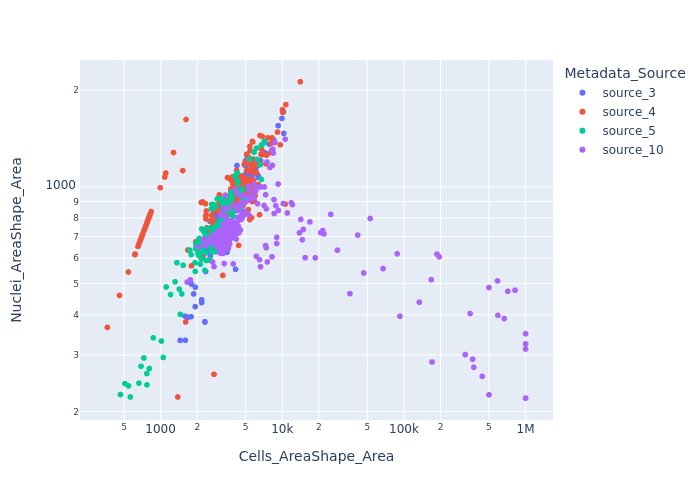

In [9]:
px.scatter(ann_dframe, x='Cells_AreaShape_Area',
           y='Nuclei_AreaShape_Area',
           color='Metadata_Source',
           hover_name='Metadata_JCP2022',
           log_x=True, log_y=True)